In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [8]:
# importing the data
raw_csv_data = pd.read_excel(r"C:\Users\Akrishta\Downloads\Projects\TimeSeries\Data\CallCenterData.xlsx")

In [9]:
# check point of data
df_comp = raw_csv_data.copy()

In [10]:
df_comp.head()

,month,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
0,2010-01-31,631,8,6,2,19,1,4
1,2010-02-28,633,9,7,3,27,1,3
2,2010-03-31,766,4,4,2,24,1,1
3,2010-04-30,768,12,6,3,32,1,1
4,2010-05-31,1003,2,7,2,42,1,4


In [11]:
df_comp.describe()

,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,9856.704545,2411.856061,514.204545,112.454545,651.681818,2.250000,2.537879
std,6221.071304,1714.759241,392.882978,69.680773,395.949633,1.867255,1.161766
min,631.000000,2.000000,4.000000,2.000000,19.000000,0.000000,1.000000
25%,3744.250000,608.750000,119.000000,39.750000,363.500000,1.000000,1.000000
50%,9651.500000,2613.500000,486.000000,130.500000,581.000000,2.000000,3.000000
75%,15590.750000,4000.500000,901.500000,171.250000,997.750000,3.000000,4.000000
max,23602.000000,5138.000000,1310.000000,229.000000,1535.000000,11.000000,4.000000


In [12]:
df_comp.isna().sum()

month            0
Healthcare       0
Telecom          0
Banking          0
Technology       0
Insurance        0
#ofphonelines    0
#noofchannels    0
dtype: int64

## Setting date as Index

In [13]:
# taken as a date time field
df_comp.month.describe()

count                     132
unique                    132
top       2010-01-31 00:00:00
freq                        1
first     2010-01-31 00:00:00
last      2020-12-31 00:00:00
Name: month, dtype: object

In [14]:
df_comp.set_index("month", inplace=True)

In [15]:
df_comp.head(6)

,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
month,,,,,,,
2010-01-31,631,8,6,2,19,1,4
2010-02-28,633,9,7,3,27,1,3
2010-03-31,766,4,4,2,24,1,1
2010-04-30,768,12,6,3,32,1,1
2010-05-31,1003,2,7,2,42,1,4
2010-06-30,1046,5,13,2,44,1,2


In [16]:
# seeting the frequency as monthly
df_comp.asfreq('M')

,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
month,,,,,,,
2010-01-31,631,8,6,2,19,1,4
2010-02-28,633,9,7,3,27,1,3
2010-03-31,766,4,4,2,24,1,1
2010-04-30,768,12,6,3,32,1,1
2010-05-31,1003,2,7,2,42,1,4
...,...,...,...,...,...,...,...
2020-08-31,20257,4486,1111,212,371,4,3
2020-09-30,19207,4474,1020,135,362,3,1
2020-10-31,23414,5138,1310,188,523,3,4


In [17]:
# seeting the frequency as monthly
df_comp = df_comp.asfreq('M')

In [18]:
# checking for the null values
df_comp.isna().sum()

Healthcare       0
Telecom          0
Banking          0
Technology       0
Insurance        0
#ofphonelines    0
#noofchannels    0
dtype: int64

## Time Series Visualization

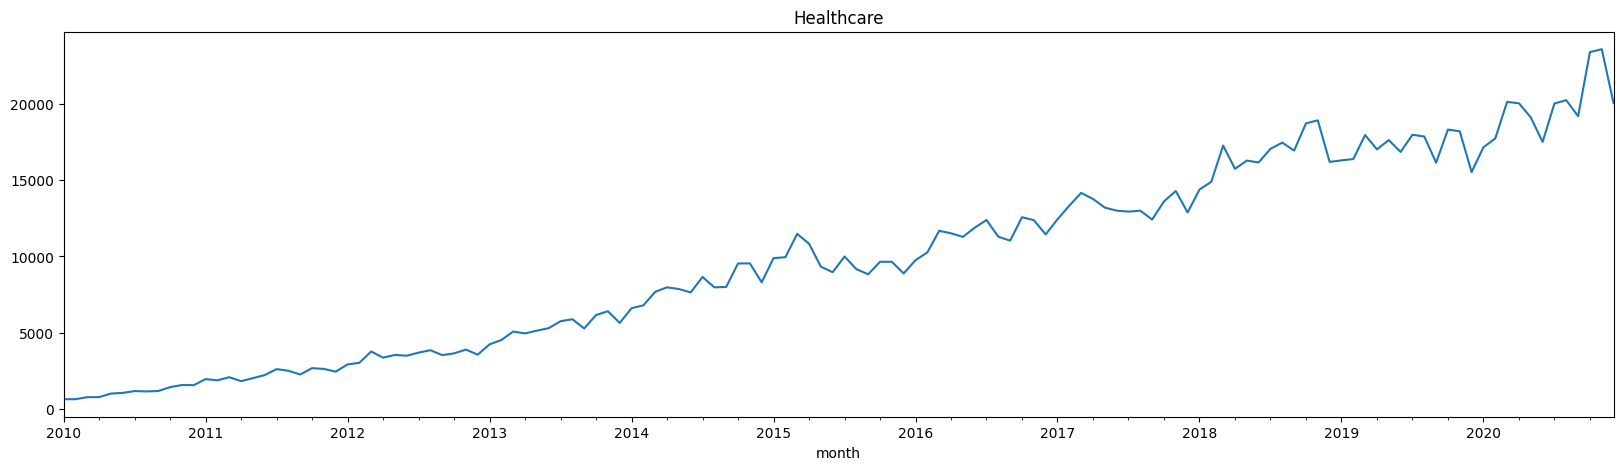

In [19]:
df_comp.Healthcare.plot(figsize=(20,5), title="Healthcare")
plt.show()

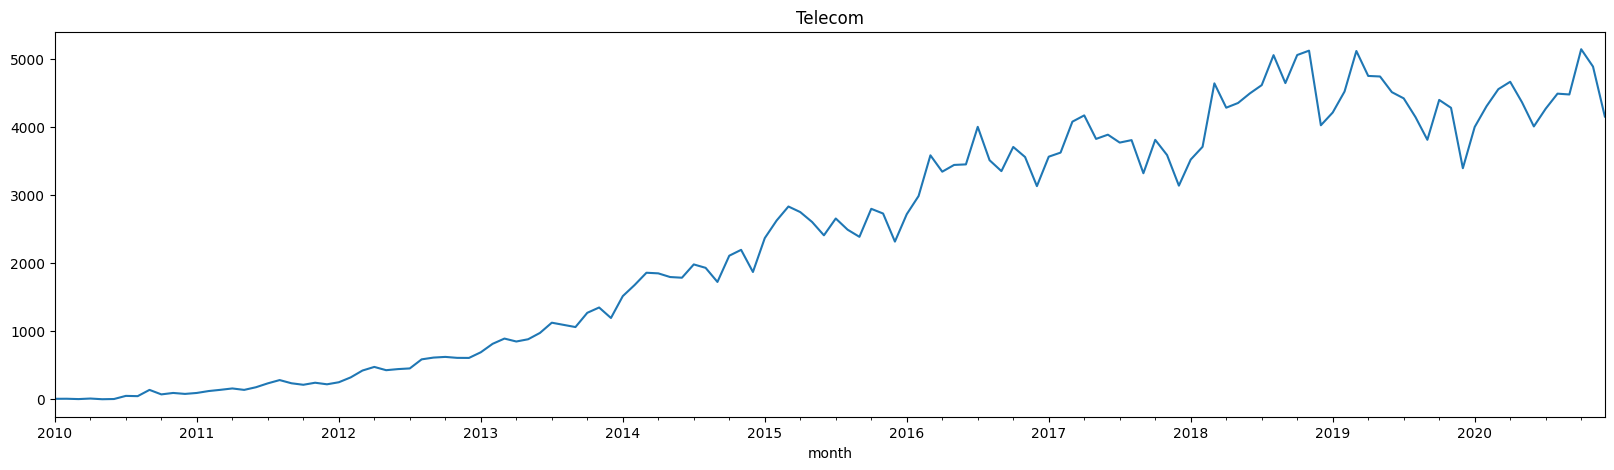

In [20]:
df_comp.Telecom.plot(figsize=(20,5), title="Telecom")
plt.show()

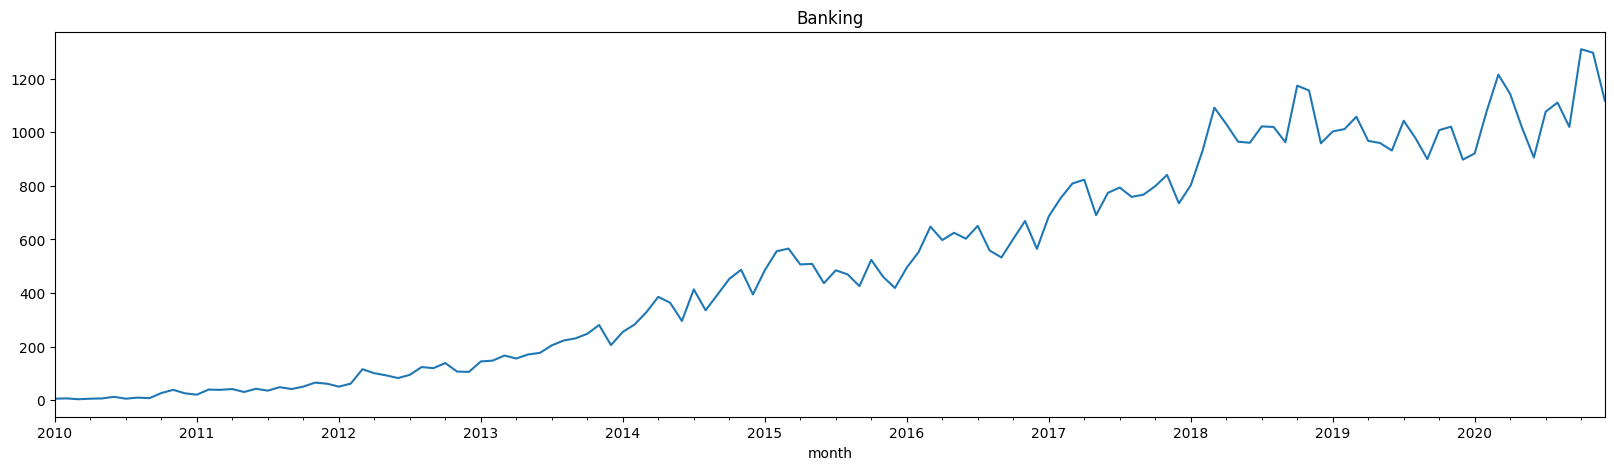

In [21]:
df_comp.Banking.plot(figsize=(20,5), title="Banking")
plt.show()

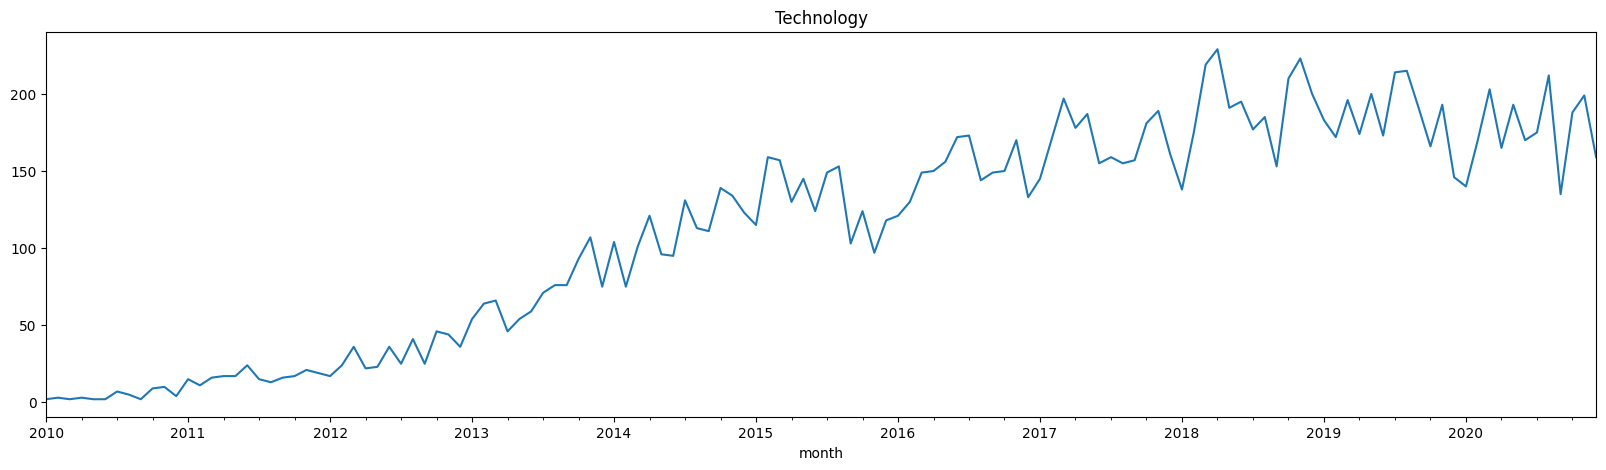

In [22]:
df_comp.Technology.plot(figsize=(20,5), title="Technology")
plt.show()

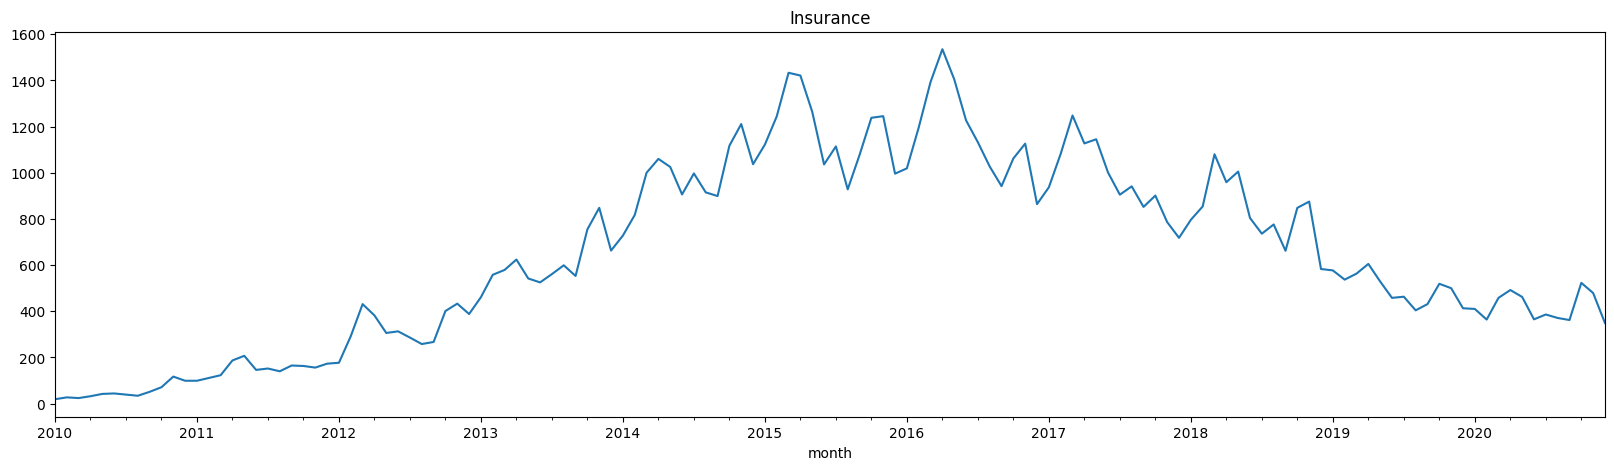

In [23]:
df_comp.Insurance.plot(figsize=(20,5), title="Insurance")
plt.show()

## Setting the training format

In [24]:
data = df_comp.Healthcare

In [27]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
target_data = []

# Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (?)
#refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(len(data)):
    temp = []
    for j in range(n_past + 1):
        try:
            temp.append(data[i+j])
        except Exception as e:
            continue
    if len(temp) > 5:
        target_data.append(temp)

len(target_data)
target_data

[[631, 633, 766, 768, 1003, 1046],
 [633, 766, 768, 1003, 1046, 1165],
 [766, 768, 1003, 1046, 1165, 1143],
 [768, 1003, 1046, 1165, 1143, 1169],
 [1003, 1046, 1165, 1143, 1169, 1424],
 [1046, 1165, 1143, 1169, 1424, 1562],
 [1165, 1143, 1169, 1424, 1562, 1552],
 [1143, 1169, 1424, 1562, 1552, 1952],
 [1169, 1424, 1562, 1552, 1952, 1872],
 [1424, 1562, 1552, 1952, 1872, 2076],
 [1562, 1552, 1952, 1872, 2076, 1817],
 [1552, 1952, 1872, 2076, 1817, 2017],
 [1952, 1872, 2076, 1817, 2017, 2214],
 [1872, 2076, 1817, 2017, 2214, 2607],
 [2076, 1817, 2017, 2214, 2607, 2498],
 [1817, 2017, 2214, 2607, 2498, 2254],
 [2017, 2214, 2607, 2498, 2254, 2671],
 [2214, 2607, 2498, 2254, 2671, 2619],
 [2607, 2498, 2254, 2671, 2619, 2441],
 [2498, 2254, 2671, 2619, 2441, 2913],
 [2254, 2671, 2619, 2441, 2913, 3024],
 [2671, 2619, 2441, 2913, 3024, 3763],
 [2619, 2441, 2913, 3024, 3763, 3359],
 [2441, 2913, 3024, 3763, 3359, 3538],
 [2913, 3024, 3763, 3359, 3538, 3485],
 [3024, 3763, 3359, 3538, 3485, 368

## Train Test Split

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
from sklearn.preprocessing import MinMaxScaler
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(target_data)
target_data_scaled = scaler.transform(target_data)

In [32]:
data_df = pd.DataFrame(target_data_scaled, columns=["t-4","t-3","t-2","t-1","t","Y"])

In [33]:
data_df.head()

,t-4,t-3,t-2,t-1,t,Y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000102,0.006777,0.000103,0.010377,0.001903,0.005276
2,0.006918,0.006879,0.012159,0.012276,0.007168,0.004300
3,0.007021,0.018854,0.014366,0.017531,0.006195,0.005453
4,0.019064,0.021046,0.020471,0.016559,0.007345,0.016758


In [34]:
# train set split
test_size = 20

train = data_df[:-test_size]
test = data_df[-test_size:]

In [35]:
X, Y = train.drop("Y", axis=1).values, train["Y"]
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state=0)


X_test, Y_test = test.drop("Y", axis=1).values, test["Y"]

## Neural Networks (Dense)

In [36]:
epochs = 100
lr = 0.0003
adam = optimizers.Adam(lr)

In [37]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


In [38]:
mlp_history = model_mlp.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), 
                            epochs=epochs, verbose=2)

Epoch 1/100
3/3 - 1s - loss: 0.1239 - val_loss: 0.1249
Epoch 2/100
3/3 - 0s - loss: 0.1095 - val_loss: 0.1100
Epoch 3/100
3/3 - 0s - loss: 0.0965 - val_loss: 0.0961
Epoch 4/100
3/3 - 0s - loss: 0.0842 - val_loss: 0.0833
Epoch 5/100
3/3 - 0s - loss: 0.0730 - val_loss: 0.0716
Epoch 6/100
3/3 - 0s - loss: 0.0627 - val_loss: 0.0608
Epoch 7/100
3/3 - 0s - loss: 0.0526 - val_loss: 0.0512
Epoch 8/100
3/3 - 0s - loss: 0.0450 - val_loss: 0.0425
Epoch 9/100
3/3 - 0s - loss: 0.0372 - val_loss: 0.0350
Epoch 10/100
3/3 - 0s - loss: 0.0309 - val_loss: 0.0285
Epoch 11/100
3/3 - 0s - loss: 0.0250 - val_loss: 0.0230
Epoch 12/100
3/3 - 0s - loss: 0.0202 - val_loss: 0.0185
Epoch 13/100
3/3 - 0s - loss: 0.0163 - val_loss: 0.0148
Epoch 14/100
3/3 - 0s - loss: 0.0132 - val_loss: 0.0118
Epoch 15/100
3/3 - 0s - loss: 0.0107 - val_loss: 0.0094
Epoch 16/100
3/3 - 0s - loss: 0.0086 - val_loss: 0.0075
Epoch 17/100
3/3 - 0s - loss: 0.0070 - val_loss: 0.0062
Epoch 18/100
3/3 - 0s - loss: 0.0057 - val_loss: 0.0051
E

In [39]:
mlp_pred = model_mlp.predict(X_test)

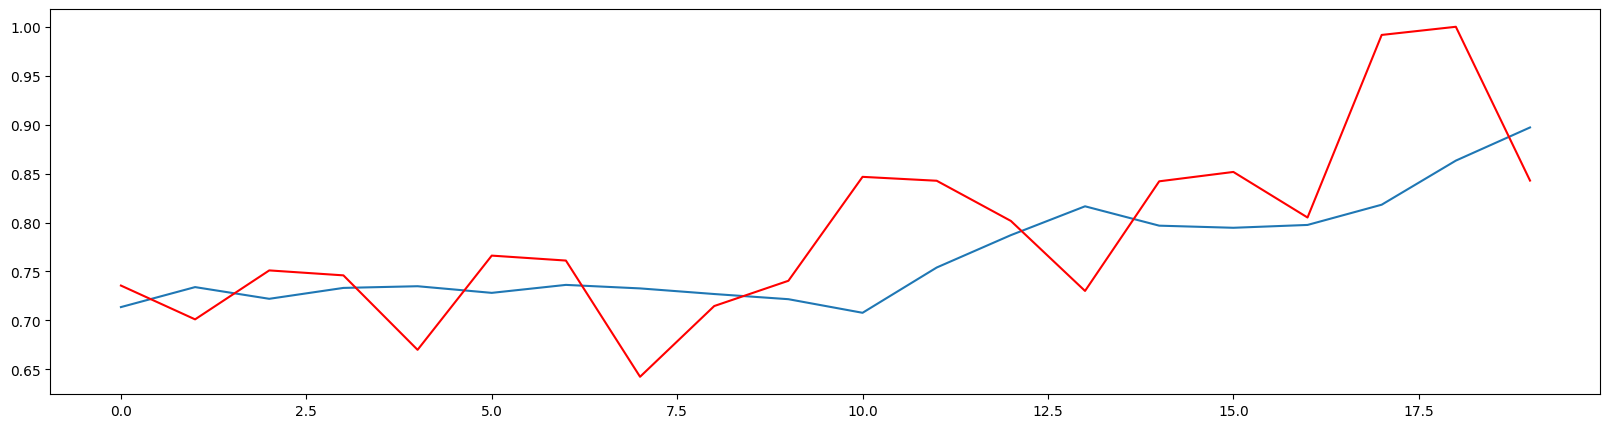

In [41]:
# plot
plt.figure(figsize=(20,5))
plt.plot(mlp_pred)
plt.plot(Y_test.values, color='red')
plt.show()

## CNN

In [42]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (96, 5, 1)
Validation set shape (11, 5, 1)


In [43]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 64)             192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 6,693
Trainable params: 6,693
Non-trainable params: 0
_________________________________________________________________


In [44]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/100
3/3 - 1s - loss: 0.1466 - val_loss: 0.1383
Epoch 2/100
3/3 - 0s - loss: 0.1140 - val_loss: 0.1012
Epoch 3/100
3/3 - 0s - loss: 0.0838 - val_loss: 0.0692
Epoch 4/100
3/3 - 0s - loss: 0.0563 - val_loss: 0.0451
Epoch 5/100
3/3 - 0s - loss: 0.0363 - val_loss: 0.0268
Epoch 6/100
3/3 - 0s - loss: 0.0213 - val_loss: 0.0136
Epoch 7/100
3/3 - 0s - loss: 0.0106 - val_loss: 0.0059
Epoch 8/100
3/3 - 0s - loss: 0.0051 - val_loss: 0.0029
Epoch 9/100
3/3 - 0s - loss: 0.0030 - val_loss: 0.0025
Epoch 10/100
3/3 - 0s - loss: 0.0027 - val_loss: 0.0025
Epoch 11/100
3/3 - 0s - loss: 0.0023 - val_loss: 0.0016
Epoch 12/100
3/3 - 0s - loss: 0.0018 - val_loss: 8.6725e-04
Epoch 13/100
3/3 - 0s - loss: 0.0016 - val_loss: 6.1050e-04
Epoch 14/100
3/3 - 0s - loss: 0.0015 - val_loss: 6.0353e-04
Epoch 15/100
3/3 - 0s - loss: 0.0013 - val_loss: 8.7964e-04
Epoch 16/100
3/3 - 0s - loss: 0.0013 - val_loss: 0.0011
Epoch 17/100
3/3 - 0s - loss: 0.0013 - val_loss: 0.0010
Epoch 18/100
3/3 - 0s - loss: 0.0013 - va

In [45]:
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
cnn_pred = model_cnn.predict(X_test_series)

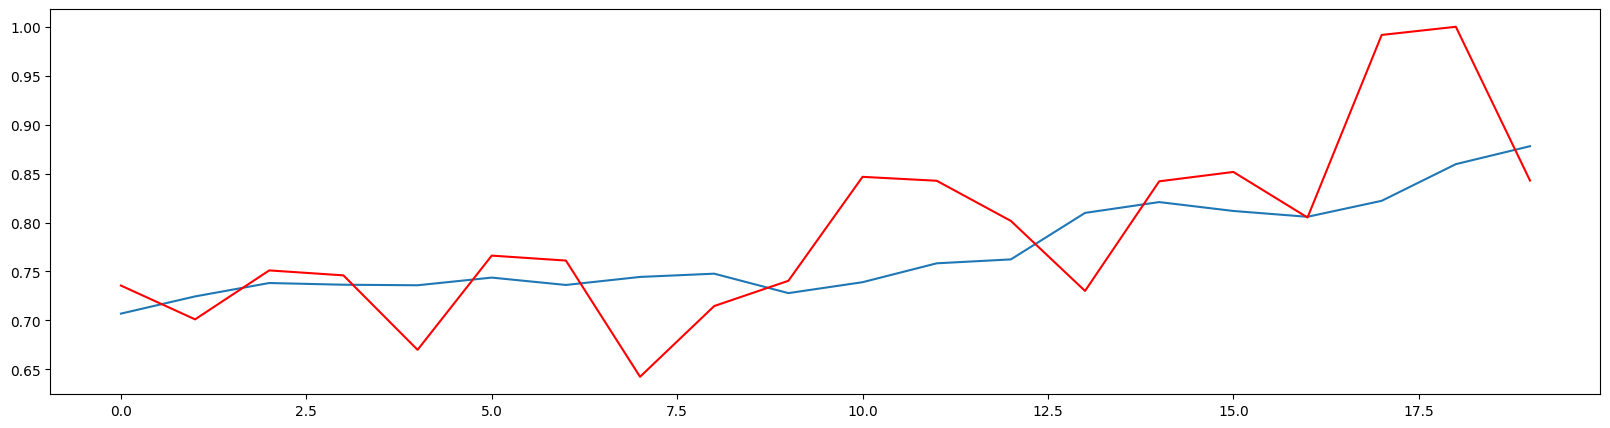

In [46]:
# plot
plt.figure(figsize=(20,5))
plt.plot(cnn_pred)
plt.plot(Y_test.values, color='red')
plt.show()

## LSTM

In [47]:
model_lstm = Sequential()
model_lstm.add(LSTM(90, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90)                33120     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 91        
Total params: 33,211
Trainable params: 33,211
Non-trainable params: 0
_________________________________________________________________


In [48]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/100
3/3 - 2s - loss: 0.1583 - val_loss: 0.1568
Epoch 2/100
3/3 - 0s - loss: 0.1340 - val_loss: 0.1250
Epoch 3/100
3/3 - 0s - loss: 0.1037 - val_loss: 0.0940
Epoch 4/100
3/3 - 0s - loss: 0.0769 - val_loss: 0.0666
Epoch 5/100
3/3 - 0s - loss: 0.0526 - val_loss: 0.0422
Epoch 6/100
3/3 - 0s - loss: 0.0311 - val_loss: 0.0228
Epoch 7/100
3/3 - 0s - loss: 0.0165 - val_loss: 0.0107
Epoch 8/100
3/3 - 0s - loss: 0.0075 - val_loss: 0.0076
Epoch 9/100
3/3 - 0s - loss: 0.0065 - val_loss: 0.0091
Epoch 10/100
3/3 - 0s - loss: 0.0071 - val_loss: 0.0076
Epoch 11/100
3/3 - 0s - loss: 0.0048 - val_loss: 0.0033
Epoch 12/100
3/3 - 0s - loss: 0.0028 - val_loss: 0.0016
Epoch 13/100
3/3 - 0s - loss: 0.0029 - val_loss: 0.0013
Epoch 14/100
3/3 - 0s - loss: 0.0026 - val_loss: 7.2471e-04
Epoch 15/100
3/3 - 0s - loss: 0.0017 - val_loss: 0.0016
Epoch 16/100
3/3 - 0s - loss: 0.0018 - val_loss: 0.0027
Epoch 17/100
3/3 - 0s - loss: 0.0019 - val_loss: 0.0018
Epoch 18/100
3/3 - 0s - loss: 0.0014 - val_loss: 9.01

In [49]:
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_pred = model_lstm.predict(X_test_series)

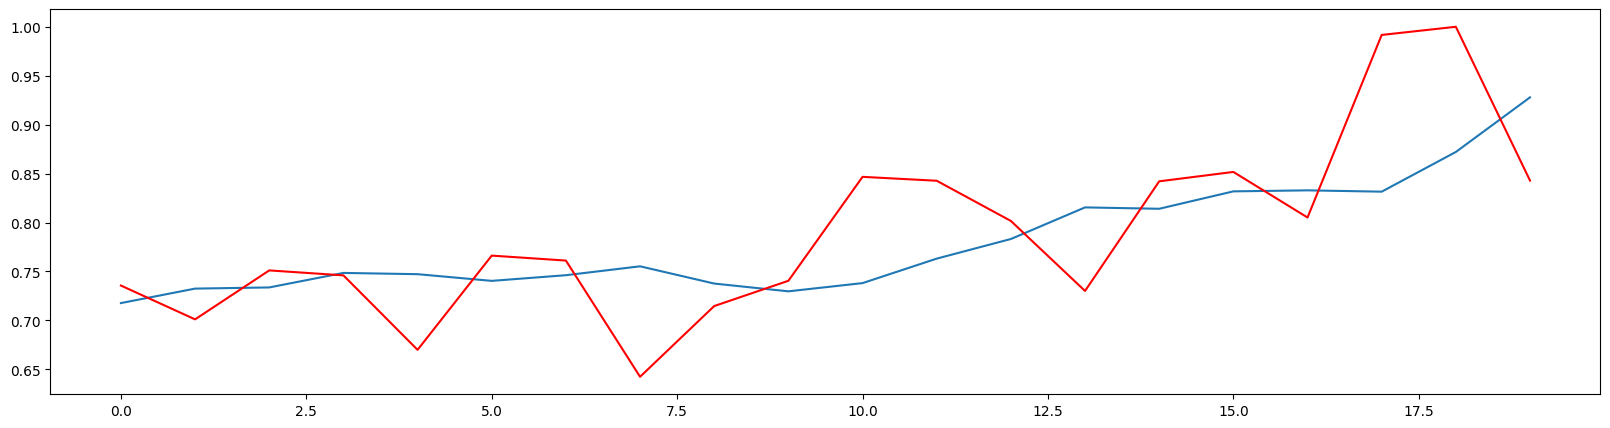

In [50]:
# plot

plt.figure(figsize=(20,5))
plt.plot(lstm_pred)
plt.plot(Y_test.values, color='red')
plt.show()

In [51]:
X_train_series.shape[1]

5

In [52]:
import math
subsequences = 2
timesteps = math.ceil(X_train_series.shape[1]/subsequences)
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], 1, 5, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], 1, 5, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)


Train set shape (96, 1, 5, 1)
Validation set shape (11, 1, 5, 1)


In [53]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [54]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/100
3/3 - 3s - loss: 0.1616 - val_loss: 0.1636
Epoch 2/100
3/3 - 0s - loss: 0.1432 - val_loss: 0.1395
Epoch 3/100
3/3 - 0s - loss: 0.1202 - val_loss: 0.1143
Epoch 4/100
3/3 - 0s - loss: 0.0982 - val_loss: 0.0901
Epoch 5/100
3/3 - 0s - loss: 0.0769 - val_loss: 0.0675
Epoch 6/100
3/3 - 0s - loss: 0.0569 - val_loss: 0.0462
Epoch 7/100
3/3 - 0s - loss: 0.0381 - val_loss: 0.0276
Epoch 8/100
3/3 - 0s - loss: 0.0216 - val_loss: 0.0140
Epoch 9/100
3/3 - 0s - loss: 0.0112 - val_loss: 0.0070
Epoch 10/100
3/3 - 0s - loss: 0.0058 - val_loss: 0.0073
Epoch 11/100
3/3 - 0s - loss: 0.0064 - val_loss: 0.0114
Epoch 12/100
3/3 - 0s - loss: 0.0088 - val_loss: 0.0138
Epoch 13/100
3/3 - 0s - loss: 0.0093 - val_loss: 0.0122
Epoch 14/100
3/3 - 0s - loss: 0.0078 - val_loss: 0.0090
Epoch 15/100
3/3 - 0s - loss: 0.0058 - val_loss: 0.0065
Epoch 16/100
3/3 - 0s - loss: 0.0049 - val_loss: 0.0053
Epoch 17/100
3/3 - 0s - loss: 0.0047 - val_loss: 0.0050
Epoch 18/100
3/3 - 0s - loss: 0.0049 - val_loss: 0.0048
E

In [57]:
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], 1, 5, 1))
cnn_lstm_pred = model_cnn_lstm.predict(X_test_series_sub)

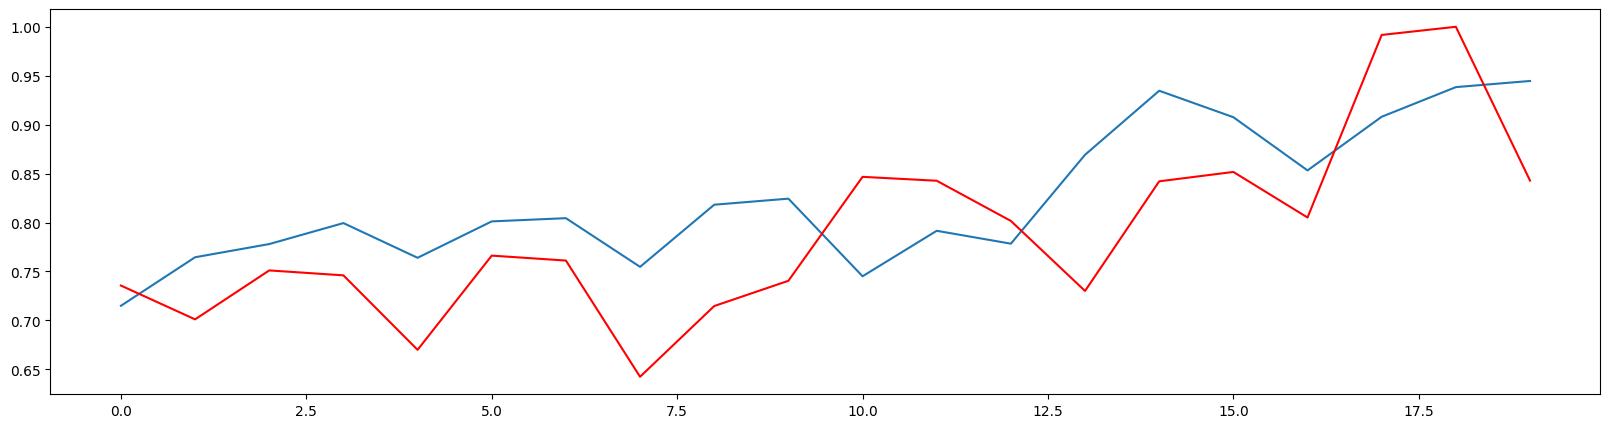

In [58]:
# plot

plt.figure(figsize=(20,5))
plt.plot(cnn_lstm_pred)
plt.plot(Y_test.values, color='red')
plt.show()